<a href="https://www.kaggle.com/code/elenashug/housing-prices-prediction?scriptVersionId=118340777" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error,mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
import xgboost
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

The main task our team faced was to consider models for predicting the cost of housing according to the available features. That is regression task should be based on decision tree models such as XGBoost -  gradient boosting and RandomForest.For evaluation models was used RMSLE metric. 

In [2]:
train_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

1. Data Understanding

In [3]:
train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


At first glance most of dataset is categorical data; there are 'Nans' that need a strategy to get rid of; 'Id'column irrelevant to the forecast and 'SalePrice' is our target:

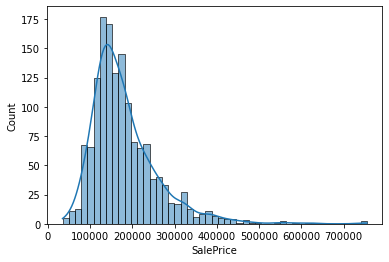

In [4]:
sns.histplot(train_data.SalePrice, kde=True);

The distribution of the target variable is similar to normal, but it is skewed, so choosing a metric RMSLE that takes the logarithm of the target will be very useful.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
train_nulls = train_data.isnull().sum().loc[(train_data.isna().sum()!=0)]
test_nulls = test_data.isnull().sum().loc[(test_data.isna().sum()!=0)]
nulls = pd.concat([train_nulls, test_nulls], axis=1)
nulls.columns=['train_nulls', 'test_nulls']
nulls

,train_nulls,test_nulls
LotFrontage,259.0,227.0
Alley,1369.0,1352.0
MasVnrType,8.0,16.0
MasVnrArea,8.0,15.0
BsmtQual,37.0,44.0
BsmtCond,37.0,45.0
BsmtExposure,38.0,44.0
BsmtFinType1,37.0,42.0
BsmtFinType2,38.0,42.0
Electrical,1.0,NaN


Also should be taken into account, that test and train data columns  containing Nans are not always the same. 
There are nulls in numerical features and generally they could be explained by the absence of factors. But the lack of data in 486 LotFrontage cases does not look so convincing. So let's fill them averages later.

Finally, we would like to evaluate the correlation between features, which required additional measures when using linear methods. 
In general, we can say that the cost of housing is largely influenced by the overall material and finish of the house and the living area of ​​square meters.

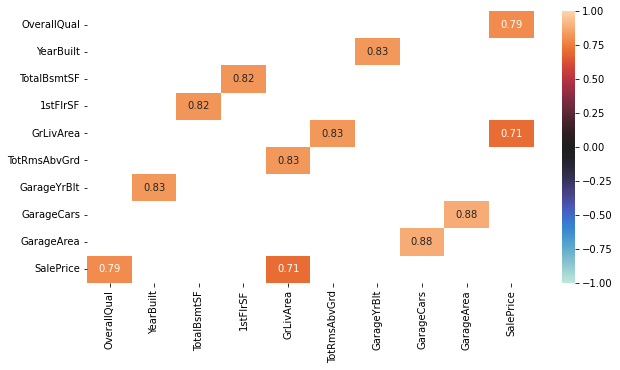

In [8]:
filtered = train_data.corr()[((train_data.corr() >= .7) | (train_data.corr() <= -.7)) & (train_data.corr() !=1.000)]
for column in filtered.columns:
    if filtered[column].isna().sum() == len(filtered):
        filtered=filtered.drop(column, axis=1)
        filtered=filtered.drop(column)
plt.figure(figsize=(10,5))
sns.heatmap(filtered, annot = True,vmin=-1, vmax=1, center= 0)
plt.show()

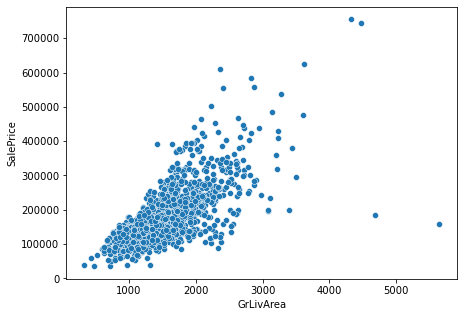

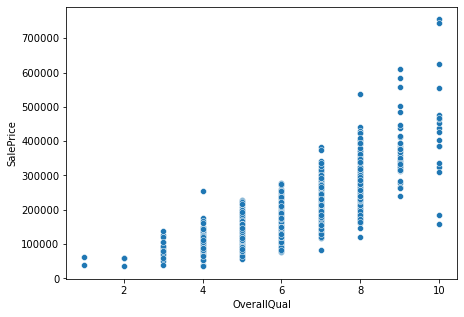

In [9]:
for i, col in enumerate(['GrLivArea', 'OverallQual']):
    plt.figure(i, figsize=(7,5))
    sns.scatterplot(x=col, y='SalePrice', data=train_data); 

The area attribute contains data with atypical correlation, above 4500 sq.ft, which can be interpreted as outliers. For linear methods, you need to get rid of them. However, the advantages of the RandomForest or Xgboost methods are:  have weak dependence on outliers, due to random sampling.. but tests we could use; they are not sensitive to scaling and other monotonous transformations of feature values; Capable of efficiently processing data with a large number of features. This way we can avoid a lot of preprocessing work.

No duplicates were found in the data:

In [10]:
data= pd.concat([train_data, test_data])
data.duplicated().sum()

0

More detailed features graphs - appendix 1 all dependency graphs 

2. Data Preparation

Divide the data into categorical and numerical and replace the empty values:

In [11]:
numerical= data.select_dtypes(np.number).columns
categorical = data.select_dtypes(object).columns

In [12]:
MeanLF = round(data['LotFrontage'].mean(),1)
data['LotFrontage'].fillna(MeanLF, inplace= True)

In [13]:
last_numerical = data[numerical].isnull().sum().loc[(data.isna().sum()>0)].index.tolist()
data[last_numerical] = SimpleImputer(strategy ='constant',fill_value= 0).fit_transform(data[last_numerical])
data[categorical]=SimpleImputer(strategy='constant').fit_transform(data[categorical])

In [14]:
data = pd.get_dummies(data,columns=categorical, drop_first = True)
train = data.iloc[:1460]
test = data.iloc[1460:]

Get rid of outliers:

In [15]:
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)
train.shape

(1458, 270)

3. Modelling

In [16]:
target = train['SalePrice']
features = train.drop(['SalePrice', 'Id'], axis=1)

Find the best model parameters:

In [17]:
Pipe = Pipeline([('preprocessing', None),('regressor', RandomForestRegressor())])
param_grid = [
    {'regressor': [XGBRegressor(n_estimators=5000, verbosity=0)],  
 'regressor__learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'regressor__max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'regressor__min_child_weight' : [ 1, 3, 5, 7 ],
 'regressor__gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'regressor__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7,1 ]
},
    {'regressor': [RandomForestRegressor(n_estimators=5000)],
               'regressor__max_depth': range(6, 30),
                'regressor__min_samples_split': range(2, 9),
                'regressor__max_features': range(2, 11),}]
rgrid = RandomizedSearchCV(Pipe,param_grid,scoring='neg_mean_squared_log_error', n_iter=5, n_jobs=-1,cv=10) 
rgrid.fit(features, target)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessing', None),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'regressor': [XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    callbacks=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=0.7,
                                                                    early_stopping_rounds=None,
                                                                    enable_categorical=False,
                 

In [18]:
print("The best_params:\n{}\n".format(rgrid.best_params_))
print("The best MSLE_cv score: {:.5f}".format(-rgrid.best_score_))


The best_params:
{'regressor__min_child_weight': 7, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.15, 'regressor__gamma': 0.1, 'regressor__colsample_bytree': 0.7, 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0.1, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)}

The best MSLE_cv score: 0.01655


We build a working model according to the parameters, the RandomizedSearchCV  help to chose XGBRegressor:

In [19]:
xgbr = xgboost.XGBRegressor( verbosity=0, booster = 'gbtree',colsample_bylevel = 0.5,colsample_bytree = 0.7,
                            min_child_weight=5,gamma = 0.4,learning_rate = 0.05,max_depth = 6,
                            n_estimators = 5000,n_jobs = -1,seed = 555)
xgbr.fit(features, target)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.4, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=5,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=555,
             reg_alpha=0, reg_lambda=1, ...)

In [20]:
y_xgbr_predict = xgbr.predict(features)
scores = cross_val_score(xgbr, features, target, scoring = 'neg_mean_squared_log_error', cv=10, n_jobs=-1)
print("Mean cross-validation MSLE score: %.5f" % -(scores.mean()))
print(f"MSLE_train: {mean_squared_log_error(target, y_xgbr_predict):.7f}")
print(f"RMSE: {mean_squared_error(target, y_xgbr_predict, squared = False):.2f}")

Mean cross-validation MSLE score: 0.01508
MSLE_train: 0.0000000
RMSE: 4.91


Let's look at the least important features from the point of view our model:

In [21]:
feature_names = features.columns
f_imp_xgbr = xgbr.feature_importances_
t = sorted(zip(f_imp_xgbr, feature_names), reverse=True)
cut_list = [y for x, y, *z in t if x ==0 ]
len(cut_list)

49

reduction parameters in the selected working model:

In [22]:
X = features.drop(cut_list, axis=1)
y = target

We apply the cross-validation method to evaluate the training score

In [23]:
xgbr.fit(X,y)
y_predict = xgbr.predict(X)
scores = cross_val_score(xgbr, X, y, scoring = 'neg_mean_squared_log_error', cv=10, n_jobs=-1)
print("Mean cross-validation MSLE score: %.5f" % -(scores.mean()))
print(f"MSLE_train: {mean_squared_log_error(y, y_predict):.7f}")
print(f"RMSE: {mean_squared_error(y, y_predict, squared = False):.2f}")

Mean cross-validation MSLE score: 0.01517
MSLE_train: 0.0000000
RMSE: 5.25


Finally, we've got a cross-validation MSLE score at the level: 0.01517.
The graph according to the training data, in the absence of test data, looks not bad...


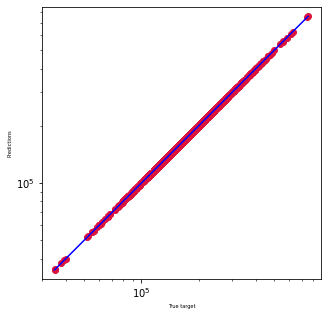

In [24]:
plt.figure(figsize=(5,5))
plt.scatter(y, y_predict, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_predict), max(y))
p2 = min(min(y_predict), min(y))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True target', fontsize=5)
plt.ylabel('Predictions', fontsize=5)
plt.axis('equal')
plt.show()

In [25]:
X_test = test.drop(['SalePrice', 'Id']+cut_list, axis=1)
y_test_predict = xgbr.predict(X_test)

In [26]:
test_Id = test['Id']
submission = pd.DataFrame({'Id': test_Id,'SalePrice': y_test_predict})
submission.to_csv("submission.csv", index=False)
submission.sample(10)

,Id,SalePrice
1256,2717,180247.937500
1390,2851,225338.765625
1127,2588,145935.562500
313,1774,117601.398438
798,2259,180292.046875
469,1930,135750.359375
1230,2691,193294.812500
611,2072,114947.242188
850,2311,191637.500000
636,2097,97664.164062


Thanks for your attention!

Appendix_1

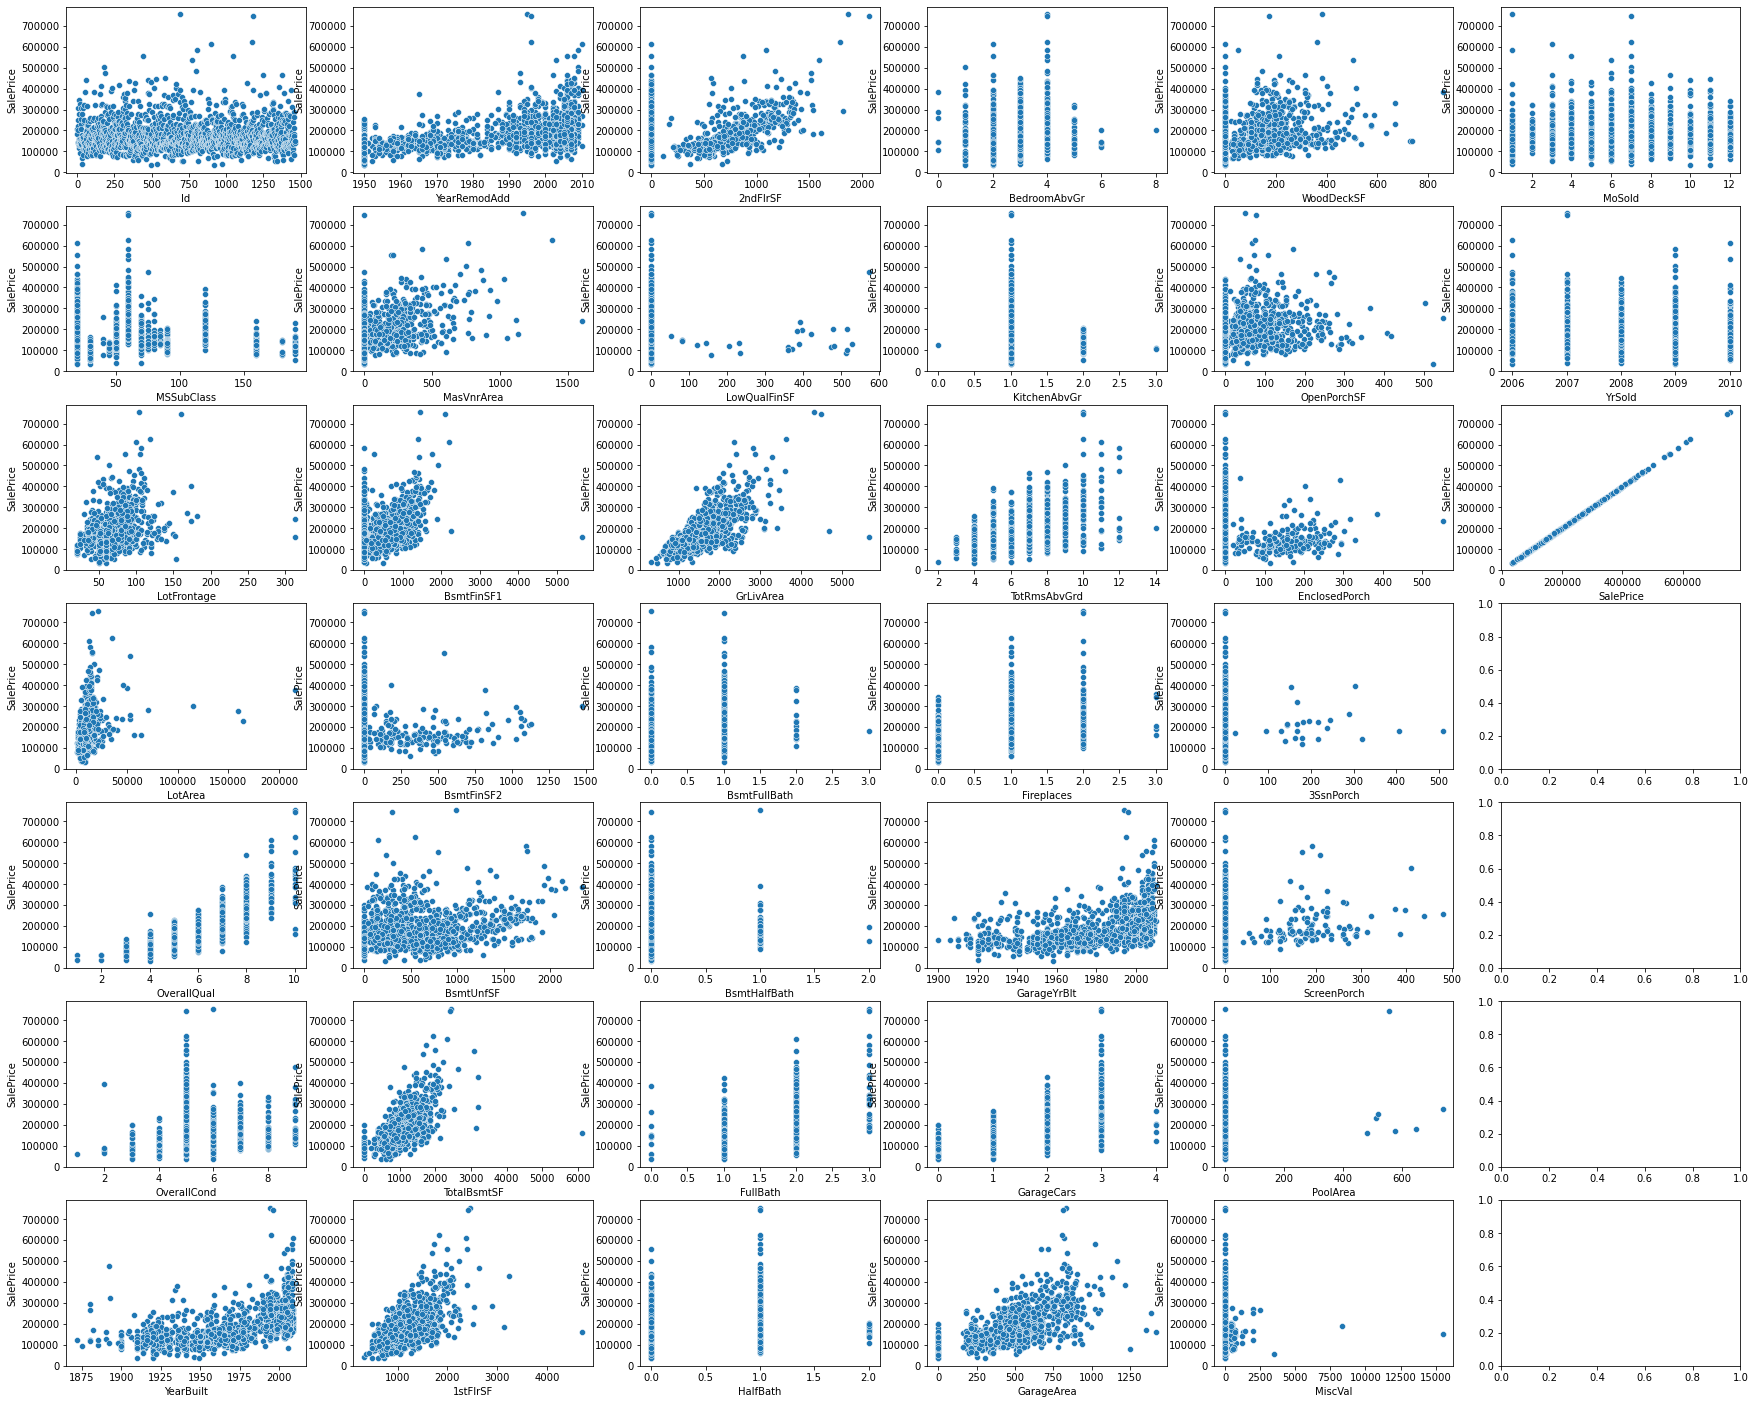

In [27]:
fig, axs = plt.subplots(7,6,figsize=(30,25),sharex=False)
for i,feature in enumerate(train_data.select_dtypes(np.number).columns): 
    sns.scatterplot(data=train_data, x=feature, y='SalePrice', ax=axs[i%7, i//7])